# Computational Social Science Project #3 

**Enter your Name:** Jacqueline Brown

*Semester:* Fall 2023

## 1. Introduction
In this project, you will learn how to develop machine learning models for classification problems. You will be working with data drawn from the City of
Chicago’s Open Data Portal. Specifically, you will develop models to predict
whether a business passes or fails a food inspection. Food safety is a major
concern for city governments, who regularly conduct food safety inspections
to ensure that establishments maintain adequate safety standards. However,
municipal governments have limited resources and cannot audit every establishment.
You have been tasked with developing an algorithm that will help the Department of Public Health prioritize establishments to audit. You have been
provided with a dataset that combines various open data sets curated by the
City of Chicago as part of a program to improve food inspection auditing. Your
goal is to predict the Results column using features taken from datasets covering business information, previous inspection results, and neighborhood information.

### Load data 

In [48]:
#
# load libraries
# -----------
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import GridSearchCV       #for hyperparameter tuning
from sklearn.metrics import accuracy_score       # for BART
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score     #for xgboost
import xgboost as xgb          # for xgboost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict

# There are a few warnings that will appear that will not affect your analysis. Run this code to ignore. 
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Make sure to import other libraries that will be necessary for training models!

In [118]:
#
# read in "Inspections Data 2011-2013" csv data
# -----------
chicago_inspections_2011_to_2013 = pd.read_csv("Chicago Inspections 2011-2013 copy.csv", 
                                              low_memory=False)

#
# read in  "Inspections Data 2014_updated" csv data
# this is the test set, so anything we do to change 2011-13 data has to be done to 2014 data. Standardization, etc!!!***
# -----------
chicago_inspections_2014 = pd.read_csv("Chicago Inspections 2014_updated copy.csv",  # be sure to use the "updated" data here
                                      low_memory=False)

In [51]:
# look at the inspections data
chicago_inspections_2011_to_2013.head()

,Inspection_ID,Inspection_Date,DBA_Name,AKA_Name,License,Facility_Type,Risk,Address,City,State,Zip,Inspection_Type,Results,Latitude,Longitude,Location,Facility_Type_Clean,criticalCount,seriousCount,minorCount,pass_flag,fail_flag,pastFail,pastCritical,pastSerious,pastMinor,timeSinceLast,firstRecord,ID,LICENSE_ID,ACCOUNT_NUMBER,LEGAL_NAME,DOING_BUSINESS_AS_NAME,ADDRESS,CITY,STATE,ZIP_CODE,WARD,PRECINCT,WARD_PRECINCT,POLICE_DISTRICT,LICENSE_CODE,LICENSE_DESCRIPTION,BUSINESS_ACTIVITY_ID,BUSINESS_ACTIVITY,LICENSE_NUMBER,APPLICATION_TYPE,LICENSE_TERM_START_DATE,LICENSE_TERM_EXPIRATION_DATE,LICENSE_STATUS,LATITUDE,LONGITUDE,minDate,maxDate,ageAtInspection,consumption_on_premises_incidental_activity,tobacco,package_goods,outdoor_patio,public_place_of_amusement,limited_business_license,childrens_services_facility_license,tavern,regulated_business_license,filling_station,caterers_liquor_license,mobile_food_license,precipIntensity,temperatureMax,windSpeed,humidity,heat_burglary,heat_garbage,heat_sanitation,criticalFound
0,269961,2013-01-31,SEVEN STAR,SEVEN STAR,30790,Grocery Store,Risk 3 (Low),3352 N BROADWAY,CHICAGO,IL,60657.0,Canvass,Pass,41.943359,-87.644999,"(41.943359344775146, -87.64499875300952)",Other,0,0,2,1,0,0,0,0,0,2.0,1,30790-20110416,2081412.0,63759.0,VIRGINIA DELA ROSA,SEVEN STAR,3352 N BROADWAY 1,CHICAGO,IL,60657.0,44.0,33.0,44-33,19.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,30790.0,RENEW,2011-04-16,2013-04-15,AAI,41.943359,-87.644999,2002-02-16,2015-04-15,10.964384,0,1,0,0,0,1,0,0,0,0,0,0,0.014587,53.496667,13.340000,0.900000,26.992376,12.768572,37.748787,0
1,507211,2011-10-18,PANERA BREAD,PANERA BREAD,1475890,Restaurant,Risk 1 (High),6059 N LINCOLN AVE,CHICAGO,IL,60659.0,Canvass,Pass,41.991919,-87.709631,"(41.99191947239194, -87.70963133440333)",Restaurant,0,0,3,1,0,0,0,0,0,2.0,1,1475890-20110416,2081695.0,207283.0,"PANERA, LLC",PANERA BREAD,6059 N LINCOLN AVE C,CHICAGO,IL,60659.0,50.0,23.0,50-23,24.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,1475890.0,RENEW,2011-04-16,2013-04-15,AAI,41.991919,-87.709631,2004-05-05,2019-04-15,7.457534,0,0,0,0,0,0,0,0,0,0,0,0,0.001907,59.046667,13.016667,0.550000,13.976557,12.895485,15.412267,0
2,507212,2011-10-18,LITTLE QUIAPO RESTAURANT,LITTLE QUIAPO RESTAURANT,1740130,Restaurant,Risk 1 (High),6259 N MCCORMICK RD,CHICAGO,IL,60659.0,Canvass,Fail,41.995632,-87.712707,"(41.99563177556418, -87.71270678169132)",Restaurant,0,2,6,0,1,0,0,0,0,2.0,1,1740130-20110216,2070145.0,3107.0,ENELITA GARCIA,LITTLE QUIAPO RESTAURANT,6259 N MCCORMICK RD,CHICAGO,IL,60659.0,50.0,25.0,50-25,17.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,1740130.0,RENEW,2011-02-16,2013-02-15,AAI,41.995632,-87.712707,2007-03-22,2017-02-15,4.578082,0,0,0,0,0,0,0,0,0,0,0,0,0.001907,59.046667,13.016667,0.550000,12.611239,8.004220,8.320330,0
3,507216,2011-10-19,SERGIO'S TAQUERIA PIZZA INC.,SERGIO'S TAQUERIA PIZZA,1447363,Restaurant,Risk 1 (High),3253 W BRYN MAWR AVE,CHICAGO,IL,60659.0,Canvass,Pass,41.982933,-87.710982,"(41.982933189164974, -87.71098225381141)",Restaurant,0,0,6,1,0,0,0,0,0,2.0,1,1447363-20110216,2071895.0,270993.0,SERGIO'S TAZUERIA PIZZA INC.,SERGIO'S TAQUERIA PIZZA INC.,3253 W BRYN MAWR AVE,CHICAGO,IL,60659.0,39.0,48.0,39-48,17.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,1447363.0,RENEW,2011-02-16,2013-02-15,AAI,41.982933,-87.710982,2003-12-31,2019-02-15,7.805479,0,0,0,0,0,0,0,0,0,0,0,0,0.002737,56.153333,10.863333,0.616667,35.906383,26.238645,38.186618,0
4,507219,2011-10-20,TARGET STORE # T-2079,TARGET,1679459,Restaurant,Risk 2 (Medium),2112 W PETERSON AVE,CHICAGO,IL,60659.0,Canvass,Fail,41.990729,-87.682979,"(41.99072921796059, -87.68297945359863)",Restaurant,0,2,6,0,1,0,0,0,0,2.0,1,1679459-20100216,2009972.0,15538.0,TARGET CORPORATION,TARGET STORE # T-2079,2112 W PETERSON AVE,CHICAGO,IL,60659.0,40.0,18.0,40-18,24.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,1679459.0,RENEW,

In [52]:
# list column names
chicago_inspections_2011_to_2013.columns

Index(['Inspection_ID', 'Inspection_Date', 'DBA_Name', 'AKA_Name', 'License',
       'Facility_Type', 'Risk', 'Address', 'City', 'State', 'Zip',
       'Inspection_Type', 'Results', 'Latitude', 'Longitude', 'Location',
       'Facility_Type_Clean', 'criticalCount', 'seriousCount', 'minorCount',
       'pass_flag', 'fail_flag', 'pastFail', 'pastCritical', 'pastSerious',
       'pastMinor', 'timeSinceLast', 'firstRecord', 'ID', 'LICENSE_ID',
       'ACCOUNT_NUMBER', 'LEGAL_NAME', 'DOING_BUSINESS_AS_NAME', 'ADDRESS',
       'CITY', 'STATE', 'ZIP_CODE', 'WARD', 'PRECINCT', 'WARD_PRECINCT',
       'POLICE_DISTRICT', 'LICENSE_CODE', 'LICENSE_DESCRIPTION',
       'BUSINESS_ACTIVITY_ID', 'BUSINESS_ACTIVITY', 'LICENSE_NUMBER',
       'APPLICATION_TYPE', 'LICENSE_TERM_START_DATE',
       'LICENSE_TERM_EXPIRATION_DATE', 'LICENSE_STATUS', 'LATITUDE',
       'LONGITUDE', 'minDate', 'maxDate', 'ageAtInspection',
       'consumption_on_premises_incidental_activity', 'tobacco',
       'package_goods',

In [119]:
# drop column names related to geography, identification, and pass/fail flags that perfectly predict the outcome
chicago_inspections_2011_to_2013.drop(columns = ['AKA_Name', 
                                                 'License',
                                                 'Address',
                                                 'City',
                                                 'State',
                                                 'Zip',
                                                 'Latitude',
                                                 'Longitude',
                                                 'Location',
                                                 'ID',
                                                 'LICENSE_ID',
                                                 'LICENSE_TERM_START_DATE',
                                                 'LICENSE_TERM_EXPIRATION_DATE',
                                                 'LICENSE_STATUS',
                                                 'ACCOUNT_NUMBER',
                                                 'LEGAL_NAME',
                                                 'DOING_BUSINESS_AS_NAME',
                                                 'ADDRESS',
                                                 'CITY',
                                                 'STATE',
                                                 'ZIP_CODE',
                                                 'WARD',
                                                 'PRECINCT',
                                                 'LICENSE_CODE',
                                                 'BUSINESS_ACTIVITY_ID',
                                                 'BUSINESS_ACTIVITY',
                                                 'LICENSE_NUMBER',
                                                 'LATITUDE',
                                                 'LONGITUDE',
                                                 'pass_flag',
                                                 'fail_flag'],
                                     inplace = True)

# set index
chicago_inspections_2011_to_2013.set_index(['Inspection_ID', 'DBA_Name'], inplace = True)

In [121]:
# DOING THE SAME FOR 2014

# drop column names related to geography, identification, and pass/fail flags that perfectly predict the outcome
chicago_inspections_2014.drop(columns = ['AKA_Name', 
                                                 'License',
                                                 'Address',
                                                 'City',
                                                 'State',
                                                 'Zip',
                                                 'Latitude',
                                                 'Longitude',
                                                 'Location',
                                                 'ID',
                                                 'LICENSE_ID',
                                                 'LICENSE_TERM_START_DATE',
                                                 'LICENSE_TERM_EXPIRATION_DATE',
                                                 'LICENSE_STATUS',
                                                 'ACCOUNT_NUMBER',
                                                 'LEGAL_NAME',
                                                 'DOING_BUSINESS_AS_NAME',
                                                 'ADDRESS',
                                                 'CITY',
                                                 'STATE',
                                                 'ZIP_CODE',
                                                 'WARD',
                                                 'PRECINCT',
                                                 'LICENSE_CODE',
                                                 'BUSINESS_ACTIVITY_ID',
                                                 'BUSINESS_ACTIVITY',
                                                 'LICENSE_NUMBER',
                                                 'LATITUDE',
                                                 'LONGITUDE'],
                                     inplace = True)

# set index
chicago_inspections_2014.set_index(['Inspection_ID', 'DBA_Name'], inplace = True)

In [122]:
# convert the inspection date to a datetime format
chicago_inspections_2011_to_2013['Inspection_Date'] = pd.to_datetime(chicago_inspections_2011_to_2013['Inspection_Date'])

# doing the same for 2014
chicago_inspections_2014['Inspection_Date'] = pd.to_datetime(chicago_inspections_2014['Inspection_Date'])


In [131]:
chicago_inspections_2011_to_2013.columns

Index(['Facility_Type', 'Risk', 'Inspection_Type', 'Results',
       'Facility_Type_Clean', 'criticalCount', 'seriousCount', 'minorCount',
       'pastFail', 'pastCritical', 'pastSerious', 'pastMinor', 'timeSinceLast',
       'firstRecord', 'WARD_PRECINCT', 'POLICE_DISTRICT',
       'LICENSE_DESCRIPTION', 'APPLICATION_TYPE', 'ageAtInspection',
       'consumption_on_premises_incidental_activity', 'tobacco',
       'package_goods', 'outdoor_patio', 'public_place_of_amusement',
       'limited_business_license', 'childrens_services_facility_license',
       'tavern', 'regulated_business_license', 'filling_station',
       'caterers_liquor_license', 'mobile_food_license', 'precipIntensity',
       'temperatureMax', 'windSpeed', 'humidity', 'heat_burglary',
       'heat_garbage', 'heat_sanitation', 'criticalFound'],
      dtype='object')

In [132]:
chicago_inspections_2014.columns

Index(['Facility_Type', 'Risk', 'Inspection_Type', 'Facility_Type_Clean',
       'criticalCount', 'seriousCount', 'minorCount', 'pastFail',
       'pastCritical', 'pastSerious', 'pastMinor', 'timeSinceLast',
       'firstRecord', 'WARD_PRECINCT', 'POLICE_DISTRICT',
       'LICENSE_DESCRIPTION', 'APPLICATION_TYPE', 'ageAtInspection',
       'consumption_on_premises_incidental_activity', 'tobacco',
       'package_goods', 'outdoor_patio', 'public_place_of_amusement',
       'limited_business_license', 'childrens_services_facility_license',
       'tavern', 'regulated_business_license', 'filling_station',
       'caterers_liquor_license', 'mobile_food_license', 'precipIntensity',
       'temperatureMax', 'windSpeed', 'humidity', 'heat_burglary',
       'heat_garbage', 'heat_sanitation', 'criticalFound', 'Results'],
      dtype='object')

### Visualization

Let's visualize what inspections look like over time.

<Axes: title={'center': 'Inspections by Month and Year'}, xlabel='Inspection_MonthYear'>

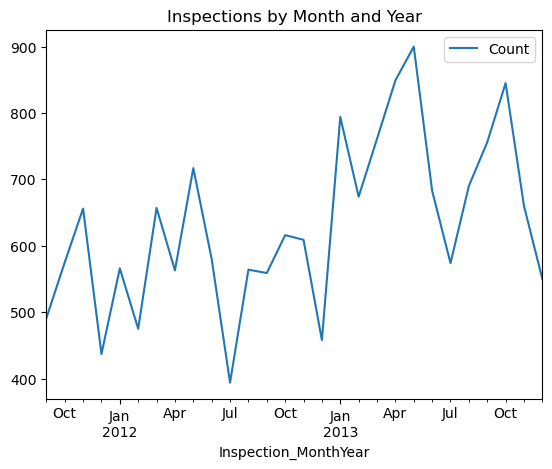

In [125]:
# visualize inspections over time
# -----------
chicago_inspections_2011_to_2013['Inspection_MonthYear'] = chicago_inspections_2011_to_2013['Inspection_Date'].dt.to_period('M')
counts_by_day = chicago_inspections_2011_to_2013.groupby('Inspection_MonthYear').count().rename(columns = {'Facility_Type': 'Count'})['Count'].reset_index()
counts_by_day.set_index(["Inspection_MonthYear"], inplace = True)
counts_by_day.plot(title = "Inspections by Month and Year") 

Let's visualize what the distribution of results looks like.

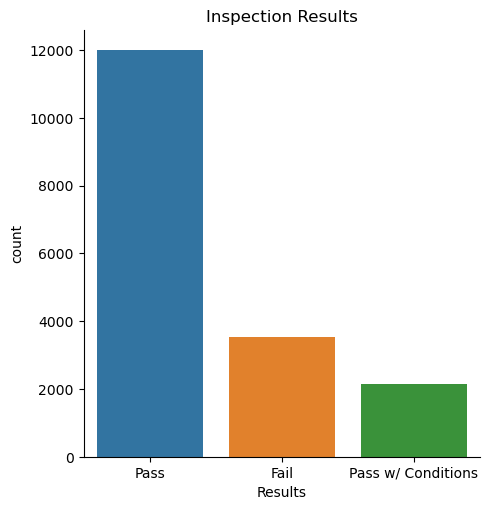

In [56]:
# view inspection results
# -----------
sns.catplot(data = chicago_inspections_2011_to_2013,
           x = "Results",
           kind = "count")

plt.title("Inspection Results")
plt.show()

What if we separate results by facility type?

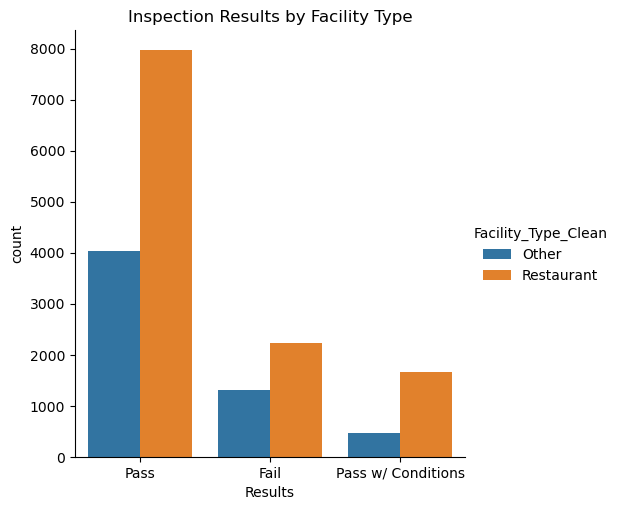

In [57]:
# view inspection results by facility type (restaurant or not)
# -----------
sns.catplot(data = chicago_inspections_2011_to_2013,
            x = "Results",
            kind = "count",
            hue = 'Facility_Type_Clean')

plt.title("Inspection Results by Facility Type")
plt.show();

## 2. Data Preprocessing and Cleaning

The “Chicago Inspections 2011-2013.csv” dataset contains data taken from eight
different datasets. The task of merging these datasets together has already
been done for you. We have also provided some preliminary visualizations and
dropped out several features. You may still wish to examine the dataset and
drop any other features you believe will not be helpful. Also, make sure to
examine the target variable and determine whether you wish to keep it as three
possible categories, or if it should be recoded as a binary label.

In [126]:
# drop datetime info
# -----------
chicago_inspections_2011_to_2013 = chicago_inspections_2011_to_2013.dropna().drop(['Inspection_Date',
                                                                                   'minDate',
                                                                                   'maxDate',
                                                                                   'Inspection_MonthYear'],
                                                                                  axis = 1)

# doing the same for 2014
# drop datetime info
# -----------
chicago_inspections_2014 = chicago_inspections_2014.dropna().drop(['Inspection_Date',
                                                                                   'minDate',
                                                                                   'maxDate'],
                                                                                  axis = 1)

In [127]:
# process target 
# -----------
y = chicago_inspections_2011_to_2013['Results']

# -----------
# binarize the target variable
y = y.replace({'Pass w/ Conditions': 'Pass'})
lb_style = LabelBinarizer()
y = lb_style.fit_transform(y)

# recode 0s and 1s so 1s are "Fail"
y = np.where(y == 1, 0 ,1)


# process features
# -----------

# create feature dataset
X = chicago_inspections_2011_to_2013.drop(columns = ['Results'])

# get dummies
X = pd.get_dummies(X)

In [128]:
# DOING SAME FOR 2014
# process target 
# -----------
y_2014 = chicago_inspections_2014['Results']

# -----------
# binarize the target variable
y_2014 = y_2014.replace({'Pass w/ Conditions': 'Pass'})
lb_style = LabelBinarizer()
y_2014 = lb_style.fit_transform(y_2014)

# recode 0s and 1s so 1s are "Fail"
y_2014 = np.where(y == 1, 0 ,1)


# process features
# -----------

# create feature dataset
X_2014 = chicago_inspections_2014.drop(columns = ['Results'])

# get dummies
X_2014 = pd.get_dummies(X_2014)

In [135]:
# view feature datset
X.head()

criticalCount  seriousCount  \
Inspection_ID DBA_Name                                                    
269961        SEVEN STAR                                0             0   
507211        PANERA BREAD                              0             0   
507212        LITTLE QUIAPO RESTAURANT                  0             2   
507216        SERGIO'S TAQUERIA PIZZA INC.              0             0   
507219        TARGET STORE # T-2079                     0             2   

                                            minorCount  pastFail  \
Inspection_ID DBA_Name                                             
269961        SEVEN STAR                             2         0   
507211        PANERA BREAD                           3         0   
507212        LITTLE QUIAPO RESTAURANT               6         0   
507216        SERGIO'S TAQUERIA PIZZA INC.           6         0   
507219        TARGET STORE # T-2079                  6         0   

                                            pastCritical  pastSerious  \
Inspection_ID DBA_Name                                                  
269961        SEVEN STAR                               0            0   
507211        PANERA BREAD                             0            0   
507212        LITTLE QUIAPO RESTAURANT                 0            0   
507216        SERGIO'S TAQUERIA PIZZA INC.             0            0   
507219        TARGET STORE # T-2079                    0            0   

                                            pastMinor  timeSinceLast  \
Inspection_ID DBA_Name                                                 
269961        SEVEN STAR                            0            2.0   
507211        PANERA BREAD                          0            2.0   
507212        LITTLE QUIAPO RESTAURANT              0            2.0   
507216        SERGIO'S TAQUERIA PIZZA INC.          0            2.0   
507219        TARGET STORE # T-2079                 0            2.0   

                                            firstRecord  POLICE_DISTRICT  \
Inspection_ID DBA_Name                                                     
269961        SEVEN STAR                              1             19.0   
507211        PANERA BREAD                            1             24.0   
507212        LITTLE QUIAPO RESTAURANT                1             17.0   
507216        SERGIO'S TAQUERIA PIZZA INC.            1             17.0   
507219        TARGET STORE # T-2079                   1             24.0   

                                            ageAtInspection  \
Inspection_ID DBA_Name                                        
269961        SEVEN STAR                          10.964384   
507211        PANERA BREAD                         7.457534   
507212        LITTLE QUIAPO RESTAURANT             4.578082   
507216        SERGIO'S TAQUERIA PIZZA INC.         7.805479   
507219        TARGET STORE # T-2079                5.290411   

                                            consumption_on_premises_incidental_activity  \
Inspection_ID DBA_Name                                                                    
269961        SEVEN STAR                                                              0   
507211        PANERA BREAD                                                            0   
507212        LITTLE QUIAPO RESTAURANT                                                0   
507216        SERGIO'S TAQUERIA PIZZA INC.                                            0   
507219        TARGET STORE # T-2079                                                   0   

                                            tobacco  package_goods  \
Inspection_ID DBA_Name                                               
269961        SEVEN STAR                          1              0   
507211        PANERA BREAD                        0              0   
507212        LITTLE QUIAPO RESTAURANT            0              0   
507216        SERGIO'S TAQUERIA PIZZA INC.        0          

## 3. Fit Models

Now choose 3 different machine learning techniques and apply them below. Choose from one of the algorithms we have used in lab (e.g., logistic regression, random forests, `AdaBoost()`, `xgboost()`, `VotingClassifer()`, or `BART`). 

Detail the basic logic and assumptions underlying each model, its pros/cons, and why it is a plausible choice for this problem. Also, be sure to do the following:

1. Import the appropriate library from sklearn
2. Set up a hyperparameter grid (check out our previous labs to see how to do this)
3. Find the best hyperparameters, and then fit your model (using either train/validation splits or cross-validation)

In [61]:
#Data Splitting

# Set seed
np.random.seed(10)

# training and test split 
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    train_size = .80, 
                                                    test_size=0.20,
                                                    stratify=y)

# training and validation split 
X_train, X_validate, y_train, y_validate = train_test_split(X_train, 
                                                            y_train, 
                                                            train_size = .75, 
                                                            test_size = .25, 
                                                            stratify = y_train)

In [65]:
#
# Standardization
#-----------

# load library 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

## scale the training and validation datasets
X_train_s = scaler.fit_transform(X_train)        # fit and transform the training data
X_validate_s = scaler.fit_transform(X_validate)  # fit and transform the validation data


## scale the test dataset
X_test_s = scaler.fit_transform(X_test)


## convert to datframes
X_train_s_df = pd.DataFrame(X_train_s, columns=X_train.columns)
X_validate_s_df = pd.DataFrame(X_validate_s, columns=X_validate.columns)
X_test_s_df = pd.DataFrame(X_test_s, columns=X_test.columns)

In [70]:
X_train_s_df.shape

(9186, 2042)

In [72]:
X_train.shape

(9186, 2042)

### Model 1 - Logistic Regression

In [41]:
from sklearn.linear_model import LogisticRegression

# create a model
logit_reg = LogisticRegression()

# fit the model
logit_model = logit_reg.fit(X_train_s_df, y_train)

# predict on the validation data
y_pred = logit_model.predict(X_validate_s_df)

In [43]:
#hyperparameter tuning
## TO ASK KASEY: WHY THE ERRORS? 

# set parameters - reduced for time purposes
param_grid = {'penalty': ['l1', 'l2', 'elasticnet'],
             'solver': ['liblinear', 'saga']}


# execute the grid search and fit to training data
logit_grid = GridSearchCV(logit_model, 
                          param_grid, 
                          cv=3)
logit_grid.fit(X_train_s_df, 
               y_train)

# choose best performing model
best_index = np.argmax(logit_grid.cv_results_["mean_test_score"])
best_logit_pred = logit_grid.best_estimator_.predict(X_validate_s_df)

# print results
print(logit_grid.cv_results_["params"][best_index])
print('Validation Accuracy', accuracy_score(best_logit_pred, y_validate))

/Users/jacquelinebrown/anaconda3/envs/CSS/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
6 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jacquelinebrown/anaconda3/envs/CSS/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jacquelinebrown/anaconda3/envs/CSS/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jacquelinebrown/anacon

{'penalty': 'elasticnet', 'solver': 'liblinear'}
Validation Accuracy 0.8984323971260614


###  Model 2 - XGBoost

In [114]:
xgb_classifier = xgb.XGBClassifier(random_state=10)


# define the scoring metrics
scoring = {
          'accuracy': make_scorer(accuracy_score),
          'recall': make_scorer(recall_score),
          'precision': make_scorer(precision_score),
          'f1': make_scorer(f1_score)
          }


# perform cross-validation with 5-fold and return the trained estimators
cv_results = cross_validate(xgb_classifier,        # specify estimator 
                            X_train_s_df, 
                            y_train.ravel(),             # specify outcome, and use ravel
                            cv=5,                  # specify 5-fold cross validation
                            return_estimator=True, # return the estimators fitted at each split
                            scoring=scoring)       # which scoring metrics to return (the whole list in this case)
 
# print the results for accuracy, recall, precision, and F1 score
for metric in ['test_accuracy', 'test_recall', 'test_precision', 'test_f1']:
    scores = cv_results[metric]
    print(f"{metric[5:]}: {scores.mean():.3f}")

accuracy: 0.924
recall: 0.861
precision: 0.785
f1: 0.821


In [46]:
# Hyperparameter tuning

# set parameters
param_grid = {'penalty': ['l1', 'l2', 'elasticnet'],
             'C': np.arange(.1, 1, .1),
             'fit_intercept': [True, False],
             'solver': ['liblinear', 'saga']}

# execute the grid search and fit to training data
xgboost_grid = GridSearchCV(xgb_classifier, 
                          param_grid, 
                          cv=3)
xgboost_grid.fit(X,
                y.ravel())

# choose best performing model
best_xgb_classifier = xgboost_grid.best_estimator_

# print the best hyperparameters
print("Best Hyperparameters:", xgboost_grid.best_params_)

# print the results for accuracy, recall, precision, and F1 score
for metric in ['mean_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score']:
    scores = xgboost_grid.cv_results_[metric]
    print(f"{metric[5:]}: {scores.mean():.3f}")


Best Hyperparameters: {'C': 0.1, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}
test_score: 0.913
0_test_score: 0.909
1_test_score: 0.913
2_test_score: 0.918


In [42]:
# test accuracy was producing an error - seeing what results are available
print(xgboost_grid.cv_results_.keys())


dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_fit_intercept', 'param_penalty', 'param_solver', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])


### Model 3 - Adaptive Boosting (Adaboost)

In [32]:
# initialize an adaptive boosting classifer 
# ----------
ada_classifier = AdaBoostClassifier(n_estimators=100)

In [115]:
# calculate accuracy using cross validation
# ----------
scores = cross_val_score(ada_classifier,  # specify classifier
                         X_train_s_df, 
                         y_train.ravel(),       # specify labels
                         cv = 5)          # specify 5-fold cross validation

In [116]:
# calculate mean score across models 
# ----------
scores.mean()

0.9182459692347426

In [117]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of weak learners
    'learning_rate': [0.01, 0.1, 0.5, 1.0]  # Weight applied to each weak learner
}

# Create the GridSearchCV object
grid_search = GridSearchCV(ada_classifier, param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X, y.ravel())

# Print the best hyperparameters found
print("Best hyperparameters:", grid_search.best_params_)

# Access the best model directly if needed
best_ada_classifier = grid_search.best_estimator_


KeyboardInterrupt: 

### Validation Metrics

Be sure to explain which of these metrics you would want to prioritize when conducting predictive auditing in this context and why.

**Hint**: Try writing a for loop to use [`cross_val_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) to check for accuracy, precision, recall and f1 across all of your models.

In [37]:
models = [logit_model, xgb_classifier, ada_classifier]  
X = X_validate  
y = y_validate  

# Define the metric functions
metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'f1': f1_score
}

# Evaluate each model
for model in models:
    print(f"Evaluating {model.__class__.__name__}:")
    y_pred = cross_val_predict(model, X, y, cv=5) 

    for metric_name, metric_func in metrics.items():
        score = metric_func(y, y_pred)
        print(f"{metric_name}: {score:.4f}")

    print("\n")

Evaluating LogisticRegression:
accuracy: 0.9112
precision: 0.7823
recall: 0.7747
f1: 0.7785


Evaluating XGBClassifier:
accuracy: 0.9086
precision: 0.7474
recall: 0.8250
f1: 0.7843


Evaluating AdaBoostClassifier:
accuracy: 0.9082
precision: 0.7523
recall: 0.8120
f1: 0.7810




## 4. Policy Simulation

### Interpretable Machine Learning

Use tools like coefficient plots or feature importance plots to investigate your models. Which features contribute to your predictions? Are there any additional features you wish you could incorporate that you don't have available in this analysis?

**Hint**: Use tools like feature importance plots and coefficient plots.

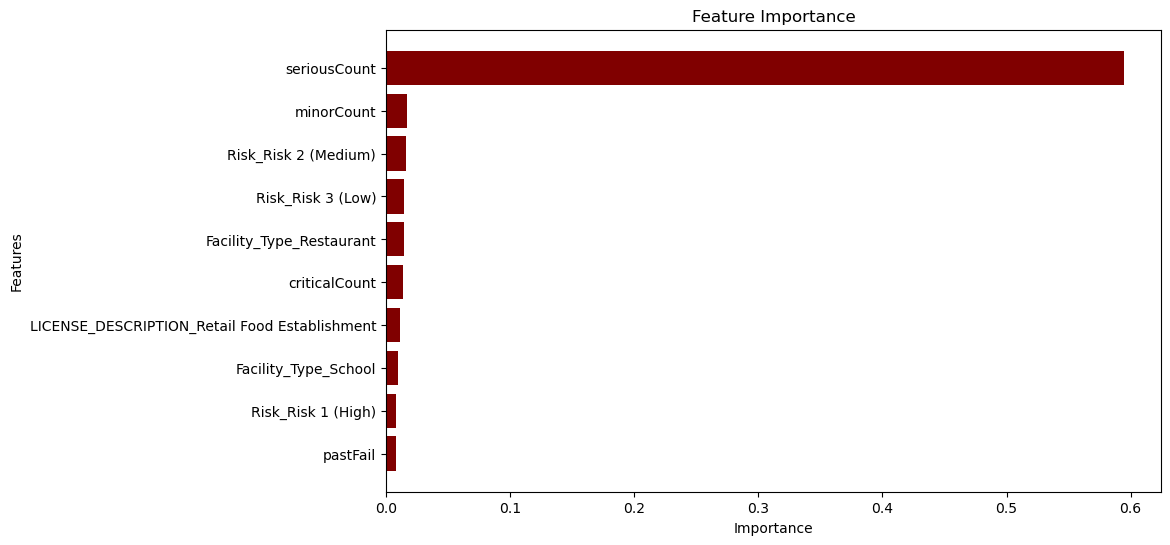

In [38]:
# Feature importance plot

# Initialize an array to hold the feature importances
importances = np.zeros(X.shape[1])

# Average the feature importances over the folds
for estimator in cv_results['estimator']:
    importances += estimator.feature_importances_
    
# Divide by the number of folds
importances /= 5  

# Create a DataFrame for visualization
feature_importance = pd.DataFrame({'feature': X.columns, 
                                   'importance': importances})

# Sort the features by importance
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Take the top 10 features
feature_importance = feature_importance.head(10)

# Plot the feature importances
plt.figure(figsize=(10, 6))

# horizontal bar plot
plt.barh(feature_importance['feature'], 
         feature_importance['importance'], 
         color='maroon', 
         align='center')

# labels
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')

# gca stands for "get current axis", which allows you to modify the properties of the axes.
# and then inverts the y-axis, meaning that the values that were at the bottom will now be at the top, and vice versa.
plt.gca().invert_yaxis() 
plt.show()

Based on the feature importance plot, it is clear that the count of "Serious" **(What is this exactly???** offenses is the most important feature. This makes sense given the data available, and given what I would expect to determine failing an inspection. Risk level, minor/critical counts, and other descriptive features have a much smaller, but relatively equal importance. Interestingly, past fails do not appear to be that important in predicting current pass rates. I don't think any other features are important to add, it seems like the data cover the most important elements of restaurant cleanliness/safety that could be measured at a large scale. 

### Prioritize Audits

**Hint**: Look up the [`.predict()`](https://www.kite.com/python/docs/sklearn.linear_model.SGDRegressor.predict), [`.predict_proba()`](https://www.kite.com/python/docs/sklearn.linear_model.LogisticRegression.predict_proba), and [`.sample()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html) methods. Then: 
1. Choose one of your models (or train a new simplified model or ensemble!) to predict outcomes and probabilities. 
2. Order your audits by their probability of detecting a "Fail" score
3. Plot your distribution of pass/fail among the first 1,000 observations in the dataset
4. Simulate random audits on the full chicago_2011_to_2013.csv dataset by picking 1,000 observations at random

In [97]:
#
# 1. Choose one of your models (or train a new simplified model or ensemble!) to predict outcomes and probabilities.
# -----------

predictions = logit_model.predict(X_test_s_df)

probs = logit_model.predict_proba(X_test_s_df)

result_df = pd.DataFrame({
    'Predictions': predictions,
    'Probability_Class_0': probs[:, 0],
    'Probability_Class_1': probs[:, 1],})


,Predictions,Probability_Class_0,Probability_Class_1
0,0,0.959217,0.040783
1,1,0.008475,0.991525
2,0,0.958829,0.041171
3,1,0.000032,0.999968
4,0,0.999264,0.000736
...,...,...,...
3058,1,0.152129,0.847871
3059,0,0.999839,0.000161
3060,0,0.999937,0.000063
3061,0,0.997827,0.002173


In [106]:
#
# 2. Order your audits by their probability of detecting a "Fail" score
# -----------

result_df_sorted = result_df.sort_values(by='Probability_Class_1', ascending=False)


result_df_sorted.head(1000)

,Predictions,Probability_Class_0,Probability_Class_1
2630,1,6.274160e-09,1.000000
476,1,1.308520e-08,1.000000
795,1,2.275117e-08,1.000000
865,1,5.469964e-08,1.000000
19,1,7.053817e-08,1.000000
...,...,...,...
2422,0,9.704090e-01,0.029591
2383,0,9.704252e-01,0.029575
1671,0,9.704694e-01,0.029531
3036,0,9.705013e-01,0.029499


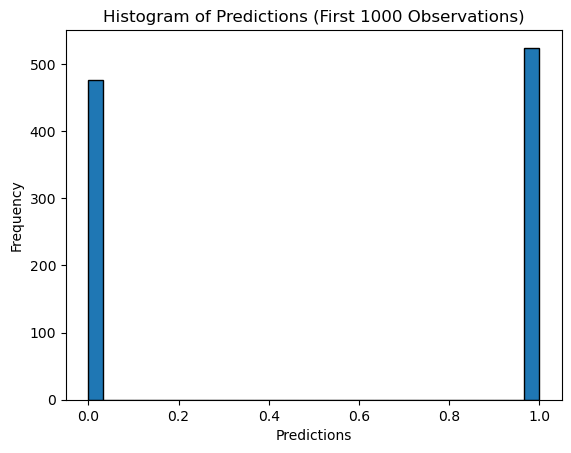

In [107]:
#
# 3. Plot your distribution of pass/fail among the first 1,000 observations in the dataset
# -----------

import matplotlib.pyplot as plt

# Assuming 'Probability_Class_1' is the column you want to create a histogram for
column_to_plot = 'Predictions'
plt.hist(result_df_sorted[column_to_plot][:1000], bins=30, edgecolor='black')
plt.title(f'Histogram of {column_to_plot} (First 1000 Observations)')
plt.xlabel(column_to_plot)
plt.ylabel('Frequency')
plt.show()


In [ ]:
#
# 4. Simulate random audits on the full chicago_2011_to_2013.csv dataset by picking 1,000 observations at random
# -----------




### Predict on 2014 inspection data

Use your favorite model to make predictions based on the features using the "Chicago Inspection 2014_updated.csv" file. Treat this as you would a test dataset. This means you will have to format the features (including removing some features and getting dummies) and the label (binarize and recode) in the same way you did the training data. (Remember the "Results" column is your label). You will then compare your predictions with the actual.

In [136]:
# data processing
# -----------

# process features

# I did this above with the 2013 data to ensure I did identical workflow


In [90]:
# process target 


#DID THIS ABOVE WITH 2013 DATA


# process features
# -----------

#DID THIS ABOVE WITH 2013 DATA

In [140]:
# predict and compare 
# -----------

# predict on the validation data
y_pred2014 = logit_model.predict(X_2014)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Facility_Type_AFTER SCHOOL PROGRAM
- Facility_Type_BUTCHER/GROCERY
- Facility_Type_GAS STATION/STORE
- Facility_Type_GELATO SHOP
- Facility_Type_HERBALIFE
- ...
Feature names seen at fit time, yet now missing:
- Facility_Type_1005
- Facility_Type_1023 CHILDERN'S SERVICE FACILITY
- Facility_Type_1023 CHILDERN'S SERVICE S FACILITY
- Facility_Type_1023 CHILDERN'S SERVICES FACILITY
- Facility_Type_1023-CHILDREN'S SERVICES FACILITY
- ...


In [139]:
# evaluate
# -----------


## 5. Discussion Questions

1. Why do we need metrics beyond accuracy when using machine learning in the social sciences and public policy?


**YOUR ANSWER HERE**...

2. Imagine that establishments learned about the algorithm being used to determine who gets audited and they started adjusting their behavior (and changing certain key features about themselves that were important for the prediction) to avoid detection. How could policymakers address this interplay between algorithmic decisionmaking and real world behavior?

**YOUR ANSWER HERE**...